Komiwojażer

chromosom - wektor zawierajacy n liczb naturalnych - numery miast(strona 40 na prezce) - funkcje do permutacji liczb losowych
f jakosci - suma odleglosci miast po koleji 

pop poczatkowa - tablica 2 wymiarowa (str 44)



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from math import sqrt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.display import display

In [52]:
# generowanie miast i populacji
def generate_cities(num_cities=10, x_range=(0, 301), y_range=(0, 301)):
    """Generacja miast - generuje określoną ilos miast z losowymi wspolrzednymi z zakresu x_range i y_range
    num_cities - liczba miast do odwiedzenia
    x_range - zakres wspolrzednych x
    y_range - zakres wspolrzednych y
    """

    cities = []
    for i in range(num_cities):
        x = random.randint(*x_range)
        y = random.randint(*y_range)
        cities.append((x, y))
    return cities

def generate_population(pop_size=50, num_cities=10):
    """Generacja populacji - tablica o dlugosci rownej ilosci miast z losowymi permutacjami kolejności ich odwiedzin
    pop_size - liczba osobnikow w populacji
    num_cities - liczba miast do odwiedzenia
    """
    
    population = []
    for _ in range(pop_size):
        el = list(range(num_cities))
        random.shuffle(el)
        population.append(el)
    return population



In [53]:
#funkcje do obliczania dystansu (fitness)

def distance(city1, city2):
    """Obliczanie odleglosci euklidesowej miedzy dwoma miastami"""

    return sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def calculate_distance_matrix(cities):   
    """Funkcja obliczajaca macierz odleglosci miedzy miastami (miasto x miasto), dzieki czemu nie musimy w kazdej iteracji obliczac na nowo dystansu
    cities = lista wygenerowanych miast (x, y)
    """
    
    num_cities = len(cities) 
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = distance(cities[i], cities[j])                 
    return distance_matrix


def fitness(route, distance_matrix):
    """Funkcja oceny osobnika: im mniejsza wartość, tym lepiej(minimalizacja dystansu)
    route = lista kolejnosci miast (osobnik)
    distance_matrix = macierz odleglosci (miasto x miasto) 
    """
    
    total_distance = 0
    for i in range(len(route)-1):
        total_distance += distance_matrix[route[i]][route[i+1]]
    total_distance += distance_matrix[route[-1]][route[0]]  
    return total_distance  #minimalizujemy




In [ ]:
#selekcja

def sort_population(population, distance_matrix):
    """Sortowanie populacji wedlug funkcji przystosowania - zwraca posortowaną populacje, od najlepszego do najgorszego osobnika (najmiejszy dystans do najwiekszego)
    population = lista osobników (tras - kolejnosci indeksow miast)
    distance_matrix = macierz odleglosci (miasto x miasto)
    """
    
    return sorted(population, key=lambda x: fitness(x, distance_matrix)) 

def rank_selection(population, distance_matrix, selection_ratio=0.5):
    """Selekcja rankingowa - wybór tylko pewnej najlepszej części populacji do następnego rozmnażania
    population = lista osobników (tras - kolejnosci indeksow miast)
    distance_matrix = macierz odleglosci (miasto x miasto)
    Selection ratio - proporcja populacji, która ma być wybrana do następnej generacji."""

    selection_size= int(len(population) * selection_ratio)
    sorted_population = sort_population(population, distance_matrix)
    return sorted_population[:selection_size]



In [55]:
#krzyżowanie i mutacja

def legalize_child(child, size):
    """ Legalizacja dziecka - upewnienie się, że dziecko nie ma duplikatów i że wszystkie miasta są obecne w trasie
    child - dziecko (trasa)
    size - liczba miast
    """
    seen = set()
    duplicates = set()
    for num in child:
        if num in seen:
            duplicates.add(num)
        seen.add(num)
    
    missing = set(range(size)) - seen

    missing = list(missing)
    for i in range(len(child)):
        if child[i] in duplicates:
            if missing:
                duplicates.remove(child[i])
                child[i] = missing.pop()
            else:
                break  

def crossover(parent1, parent2):
    """Krzyżowanie - wymiana fragmentów tras rodziców tworząca dwójkę potomków
    parent1 - pierwszy rodzic (trasa)
    parent2 - drugi rodzic (trasa)
    """
    size = len(parent1)
    loc_start = random.randint(0, size - 1)
    loc_end = random.randint(loc_start, size - 1)

    par1_crossover = parent1[loc_start:loc_end]
    par2_crossover = parent2[loc_start:loc_end]

    child1 = parent1.copy()
    child2 = parent2.copy()
    child1[loc_start:loc_end] = par2_crossover
    child2[loc_start:loc_end] = par1_crossover

    legalize_child(child1, size)
    legalize_child(child2, size)

    return child1, child2


def mutation(individual, mutation_rate=0.05):
    """Mutacja - zamiana miejscami dwóch losowych miast w trasie
    individual - osobnik (trasa)
    mutation_rate - prawdopodobieństwo mutacji (0-1)
    """
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual


In [ ]:
#algorytm genetyczny
def genetic_algorithm(cities, pop_size=50, generations=100, mutation_rate=0.1):
    """główna funkcja, która wykonuje algorytm genetyczny
    cities - lista miast (x, y)
    pop_size - liczba osobników w populacji
    generations - liczba pokoleń
    mutation_rate - prawdopodobieństwo mutacji (0-1)
    """
    
    num_cities = len(cities)
    population = generate_population(pop_size, num_cities)
    DistanceMatrix = calculate_distance_matrix(cities)
    best_fitness_history = []
    avg_fitness_history = []
    min_fitness_history = []
    best_route_history = []
    
    for gen in range(generations):
        
        # Ocena populacji
        fitness_scores = [fitness(ind, DistanceMatrix) for ind in population]
        best_fitness = min(fitness_scores)
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        min_fitness=max(fitness_scores)
        #zapis danych o funkcji przystosowania
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        min_fitness_history.append(min_fitness)

        #zapis tras
        best_route_index = np.argmin(fitness_scores)
        best_route = population[best_route_index]   
        best_route_history.append(best_route)
        
        # Selekcja

        selected = rank_selection(population, DistanceMatrix)
        
        # Krzyżowanie
        
        random.shuffle(selected) #przemieszanie rodziców
        children = []
        
        for i in range(0, len(selected)-1, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            children.append(child1)
            children.append(child2)
        
        
        # Mutacja
        mutated_children = [mutation(child, mutation_rate) for child in children]
        
        # Tworzenie nowej populacji
        population = selected + mutated_children
        
    
    # Znajdź najlepsze rozwiązanie
    best_index = np.argmin([fitness(ind, DistanceMatrix) for ind in population])
    best_individual = population[best_index]
    best_distance = fitness(best_individual, DistanceMatrix)
    
    return best_individual, best_distance, best_fitness_history, avg_fitness_history, best_route_history, min_fitness_history




In [57]:
# Wizualizacja wyników
def plot_results( fitness_history, avg_fitness_history,min_fitness_history):
    """Wizualizacja wyników dotyczących zmian funkcji przystosowania wraz z biegiem algorytmu
    fitness_history - historia najlepszych osobników
    avg_fitness_history - historia średniej oceny
    min_fitness_history - historia najgorszych osobników
    """

    plt.figure(figsize=(15, 5))
    
    plt.plot(fitness_history, label='Najlepszy osobnik')
    plt.plot(avg_fitness_history, label='Średnia populacji')
    plt.plot(min_fitness_history, label='Najgorszy osobnik')
    plt.title('Efektywność algorytmu')
    plt.xlabel('Pokolenie')
    plt.ylabel('Długość trasy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def animate_route(cities, best_route_history, filename='route_animation.gif'):

    """Generacja Gifa - miasta na czarno, trasa końcowa na czerwono, zobrazowanie ewolucji rozwiązania na niebiesko
    cities - Lista miast
    best_route_history - historia zmian najlepszego osobnika
    filename - nazwa pliku do zapisu
    """
    
    length=len(best_route_history)
    best_route=best_route_history[-1]

    frames=50
    framerate=int(length/frames)
    best_route_history=best_route_history[::framerate]  


    fig, ax = plt.subplots(figsize=(5, 5))
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    ax.scatter(x, y, color='black')

    lines = []
    

    #generowanie linii
    def update(frame):
        ax.clear()
        ax.scatter(x, y, color='black')
        best_route_now = best_route_history[frame]
        generation=0
        for i in range(len(best_route_now)):
            city1 = cities[best_route_now[i]]
            city2 = cities[best_route_now[(i+1)%len(best_route_now)]]
            line, = ax.plot([city1[0], city2[0]], [city1[1], city2[1]], 'b-')
            lines.append(line)

            for i in range(len(best_route)):
                city1 = cities[best_route[i]]
                city2 = cities[best_route[(i+1)%len(best_route)]]
                ax.plot([city1[0], city2[0]], [city1[1], city2[1]], 'r-')
            generation=frame * framerate
        ax.set_title(f'Pokolenie: {generation}')
        return lines
    
    ani = FuncAnimation(fig, update, frames=len(best_route_history), blit=True)
    ani.save(filename, writer='imagemagick', fps=5)
    plt.close(fig) 


Selekcja Rankingowa
Najlepsza znaleziona trasa: [10, 15, 46, 29, 48, 26, 20, 18, 3, 17, 44, 34, 36, 8, 11, 47, 45, 28, 40, 43, 19, 39, 5, 27, 32, 16, 49, 24, 12, 41, 13, 2, 42, 1, 7, 35, 38, 23, 33, 4, 0, 25, 22, 9, 21, 31, 37, 6, 14, 30]
Długość najlepszej trasy: 2371.31


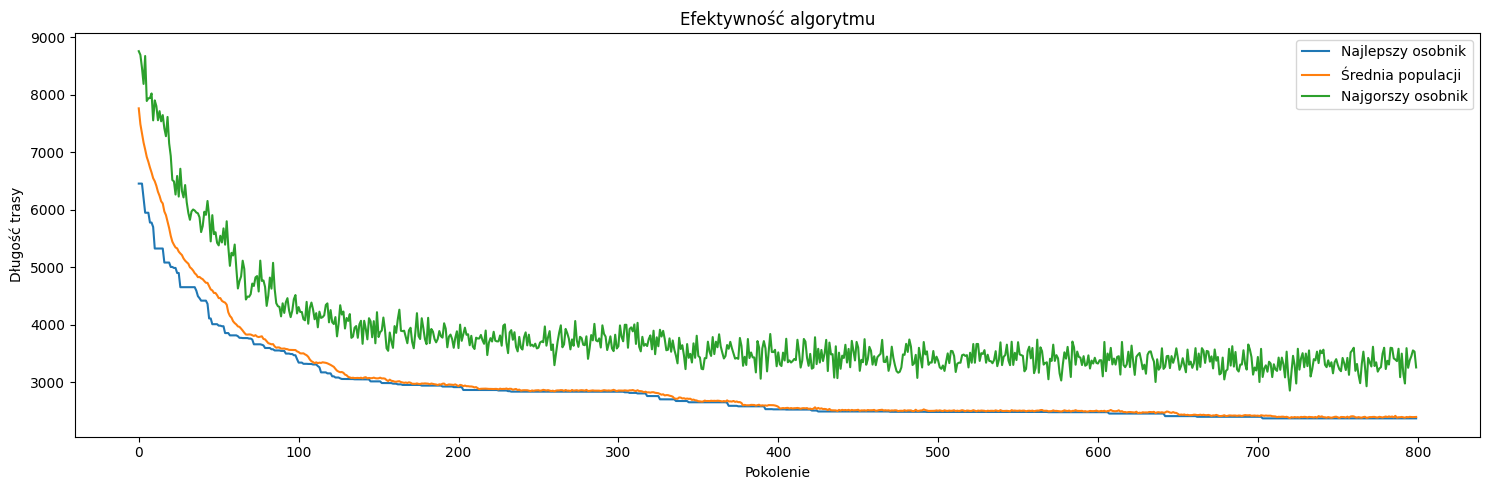

MovieWriter imagemagick unavailable; using Pillow instead.


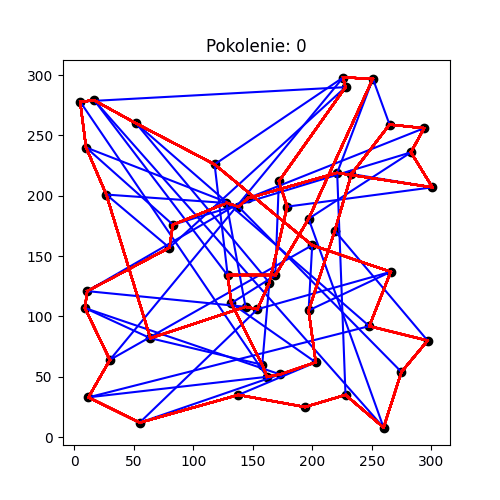

In [ ]:
# Parametry algorytmu
num_cities = 50
pop_size = 300
generations = 1000
mutation_rate = 0.1

cities = generate_cities(num_cities, x_range=(0, 301), y_range=(0, 301))

best_route, best_distance, best_fitness_history,avg_fitness_history,route_history,min_fitness_history = genetic_algorithm( cities,
pop_size, generations, mutation_rate)


print(f"Najlepsza znaleziona trasa: {best_route}")
print(f"Długość najlepszej trasy: {best_distance:.2f}")

plot_results(best_fitness_history, avg_fitness_history,min_fitness_history)

animate_route(cities, route_history, filename='route_animation.gif')
display(Image(filename='route_animation.gif'))
